<a href="https://colab.research.google.com/github/MontanezQuirozRolo/Credit_Scoring/blob/main/Credit_Scoring.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Credit Scoring**

## **1. CARGA INICIAL DE LIBRERÍAS**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Modelado y Métricas
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import (
    roc_auc_score, accuracy_score, balanced_accuracy_score,
    classification_report, confusion_matrix, brier_score_loss, roc_curve
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from sklearn.calibration import calibration_curve, CalibrationDisplay
from imblearn.over_sampling import RandomOverSampler
import shap # Para interpretabilidad


In [2]:
!pip install feature_engine

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 230.0/230.0 kB 6.0 MB/s eta 0:00:00


In [3]:
# Preprocesamiento
from feature_engine.imputation import MeanMedianImputer
from feature_engine.outliers import Winsorizer

## **2. Entendimiento y Analisis Exploratorio de datos**

Se tienen las siguientes variables


*   Default: Cliente con más de 90 dias sin pagar su prestamo
*   Prct_uso_tc: Porcentaje del uso de tarjeta de credito el último mes
*   Edad: Edad del cliente
*   Nro_prestao_retrasados: Numero de prestamos con retraso en el pago de más de 3 meses en los últimos 3 años
*   Prct_deuda_vs_ingresos: Ratio de deuda financiera vs ingresos del clientes
*   Mto_ingreso_mensual: Monto de ingreso mensual
*   Nro_prod_financieros_deuda: Nro de prestamos (incluido creditos vehiculares o hipotecario) y nro de tarjetas de credito ultimo año
*   Nro_retraso_60dias: Nro de veces que el cliente se ha retrasado más de 60 dias los últimons 3 años
*  Nro_creditos_hipotecarios: Nro de creditos hipotecarios
*  Nro_retraso_ultm3anios: Nro de retrasos en pagos de más de 30 dias en los úlitmos 3 años
*  Nro_dependiente: Nro de dependientes

## **3. CARGA Y ENTENDIMIENTO DE DATOS (EDA)**

In [4]:
try:
    df_clase = pd.read_csv('Base de Datos.csv', sep=";")
except FileNotFoundError:
    print("Asegúrate de que el archivo 'Base de Datos.csv' esté cargado.")
    # Crear un DataFrame de ejemplo si el archivo no se encuentra
    data = {'Default': np.random.randint(0, 2, 150000), 'Prct_uso_tc': np.random.rand(150000), 'Edad': np.random.randint(18, 70, 150000), 'Nro_prestao_retrasados': np.random.randint(0, 5, 150000), 'Prct_deuda_vs_ingresos': np.random.rand(150000), 'Mto_ingreso_mensual': np.random.uniform(1000, 10000, 150000), 'Nro_prod_financieros_deuda': np.random.randint(0, 10, 150000), 'Nro_retraso_60dias': np.random.randint(0, 3, 150000), 'Nro_creditos_hipotecarios': np.random.randint(0, 2, 150000), 'Nro_retraso_ultm3anios': np.random.randint(0, 4, 150000), 'Nro_dependiente': np.random.randint(0, 5, 150000), 'ID': range(150000)}
    df_clase = pd.DataFrame(data)
    df_clase['Mto_ingreso_mensual'] = df_clase['Mto_ingreso_mensual'].apply(lambda x: np.nan if np.random.rand() < 0.2 else x)
    df_clase['Nro_dependiente'] = df_clase['Nro_dependiente'].apply(lambda x: np.nan if np.random.rand() < 0.05 else x)


print(f"Forma inicial de los datos: {df_clase.shape}")
df_clase = df_clase.drop(columns=['ID']) # Eliminar ID

Forma inicial de los datos: (150000, 12)


In [5]:
# Análisis de la variable objetivo
print("\nDistribución de la variable 'Default':")
print(df_clase['Default'].value_counts(normalize=True))


Distribución de la variable 'Default':
Default
0    0.93316
1    0.06684
Name: proportion, dtype: float64


# Buen_Pagador: 139974
# 1 Mora_90D: 10026
Bad rate: 0.06684


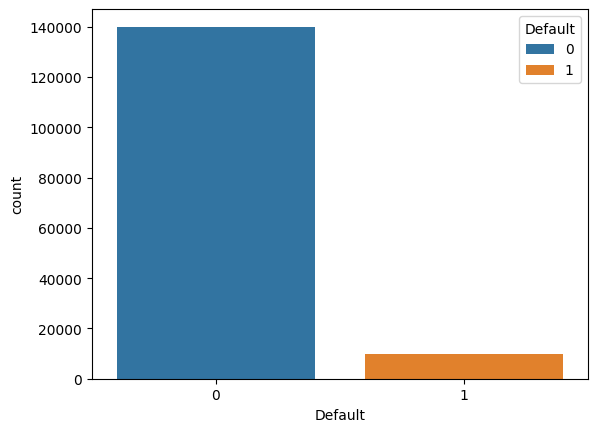

In [6]:
sns.countplot(data = df_clase, x = "Default", hue="Default")
target_count = df_clase.Default.value_counts()
print('# Buen_Pagador:', target_count[0])
print('# 1 Mora_90D:', target_count[1])
print('Bad rate:', target_count[1]/(target_count[0]+target_count[1]))

In [ ]:
# Análisis de nulos
print("\nValores nulos por columna:")
print(df_clase.isnull().mean()[df_clase.isnull().mean() > 0])


Valores nulos por columna:
Mto_ingreso_mensual    0.198207
Nro_dependiente        0.026160
dtype: float64


In [8]:
null_values = pd.concat([df_clase.isnull().sum(), df_clase.isnull().sum() / len(df_clase)], axis = 1)
null_values.rename(columns = {0: 'number_null_values',1: 'ratio_null_values'}, inplace = True)
null_values

,number_null_values,ratio_null_values
Default,0,0.000000
Prct_uso_tc,0,0.000000
Edad,0,0.000000
Nro_prestao_retrasados,0,0.000000
Prct_deuda_vs_ingresos,0,0.000000
Mto_ingreso_mensual,29731,0.198207
Nro_prod_financieros_deuda,0,0.000000
Nro_retraso_60dias,0,0.000000
Nro_creditos_hipotecarios,0,0.000000
Nro_retraso_ultm3anios,0,0.000000


In [7]:
df_clase.select_dtypes(include=['number']).describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Default,150000.0,0.066840,0.249746,0.0,0.000000,0.000000,0.000000,1.0
Prct_uso_tc,150000.0,6.048438,249.755371,0.0,0.029867,0.154181,0.559046,50708.0
Edad,150000.0,52.295207,14.771866,0.0,41.000000,52.000000,63.000000,109.0
Nro_prestao_retrasados,150000.0,0.421033,4.192781,0.0,0.000000,0.000000,0.000000,98.0
Prct_deuda_vs_ingresos,150000.0,353.005076,2037.818523,0.0,0.175074,0.366508,0.868254,329664.0
Mto_ingreso_mensual,120269.0,6670.221237,14384.674215,0.0,3400.000000,5400.000000,8249.000000,3008750.0
Nro_prod_financieros_deuda,150000.0,8.452760,5.145951,0.0,5.000000,8.000000,11.000000,58.0
Nro_retraso_60dias,150000.0,0.265973,4.169304,0.0,0.000000,0.000000,0.000000,98.0
Nro_creditos_hipotecarios,150000.0,1.018240,1.129771,0.0,0.000000,1.000000,2.000000,54.0
Nro_retraso_ultm3anios,150000.0,0.240387,4.155179,0.0,0.000000,0.000000,0.000000,98.0


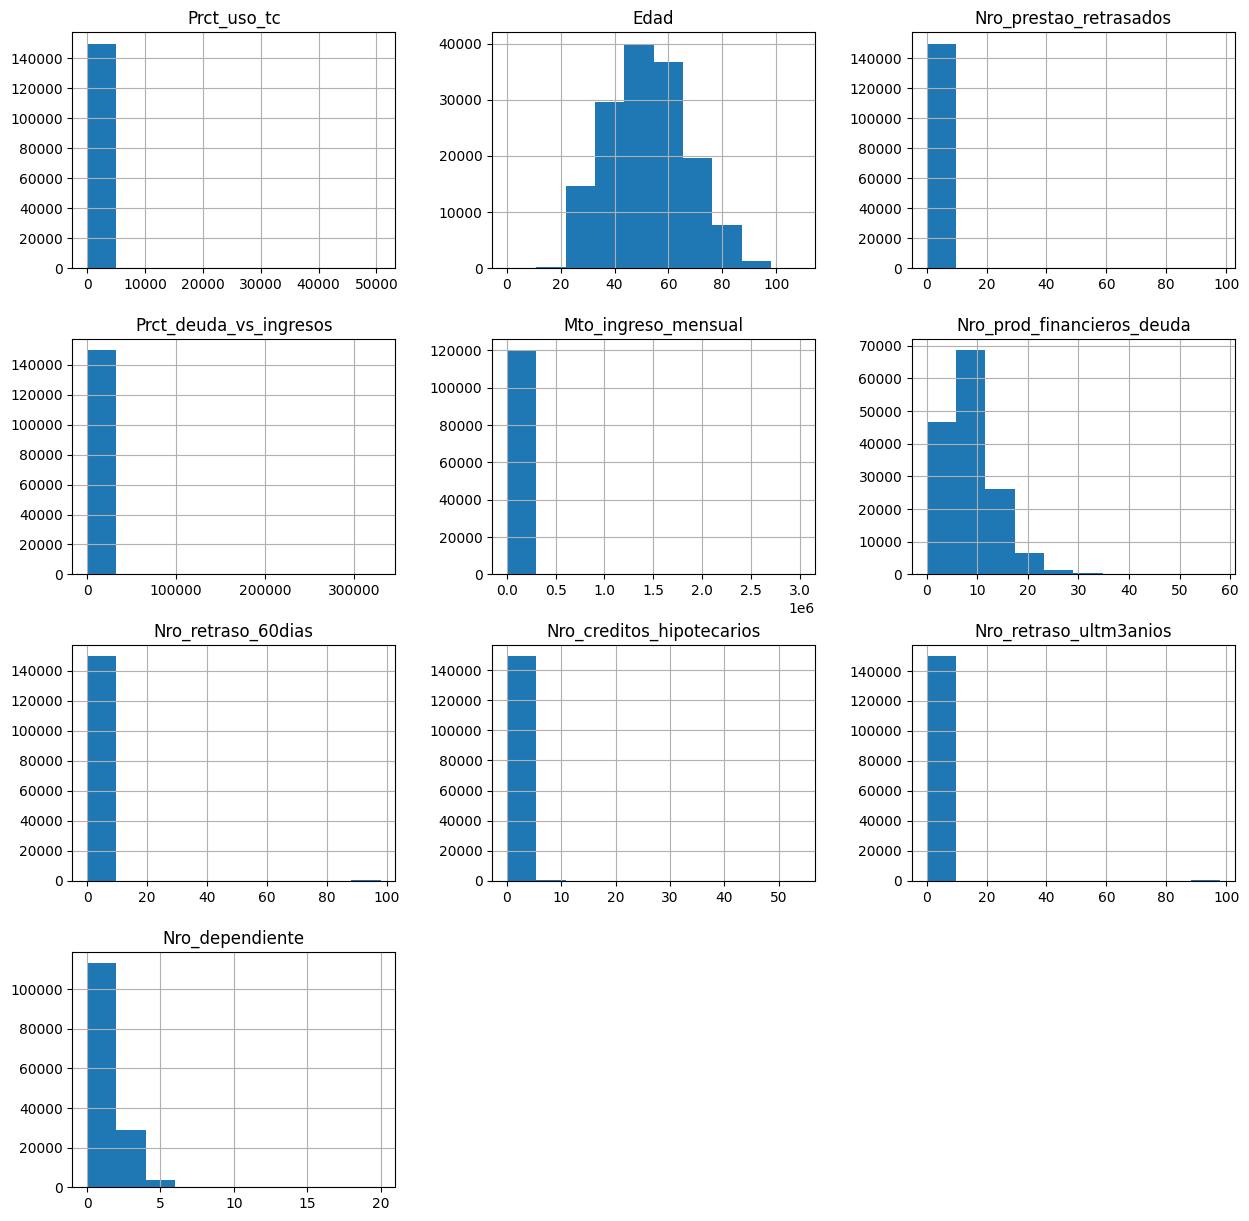

In [10]:
df_clase.drop(columns = ['Default']).hist(figsize = (15, 15)) #Quitamos Default por que es la variable de interes a predecir y ID puesto que solo es un identicador de cliente no suma al analisis
plt.show()

Las variables como Prct_uso_tc, Nro_prestao_retrasados,Prct_deuda_vs_ingresos,Mto_ingreso_mensual, Nro_prod_financieros_deuda, Nro_retraso_60dias,Nro_creditos_hipotecarios, Nro_retraso_ultm3anios y Nro_dependiente tienen una cola pesada a la derecha, lo que quiere decir que hay valores extremos en el lado derecho. Existen valores outliers por lo que tenemos esa distribucion se revisara en detalle en el siguiente grafico de cajas

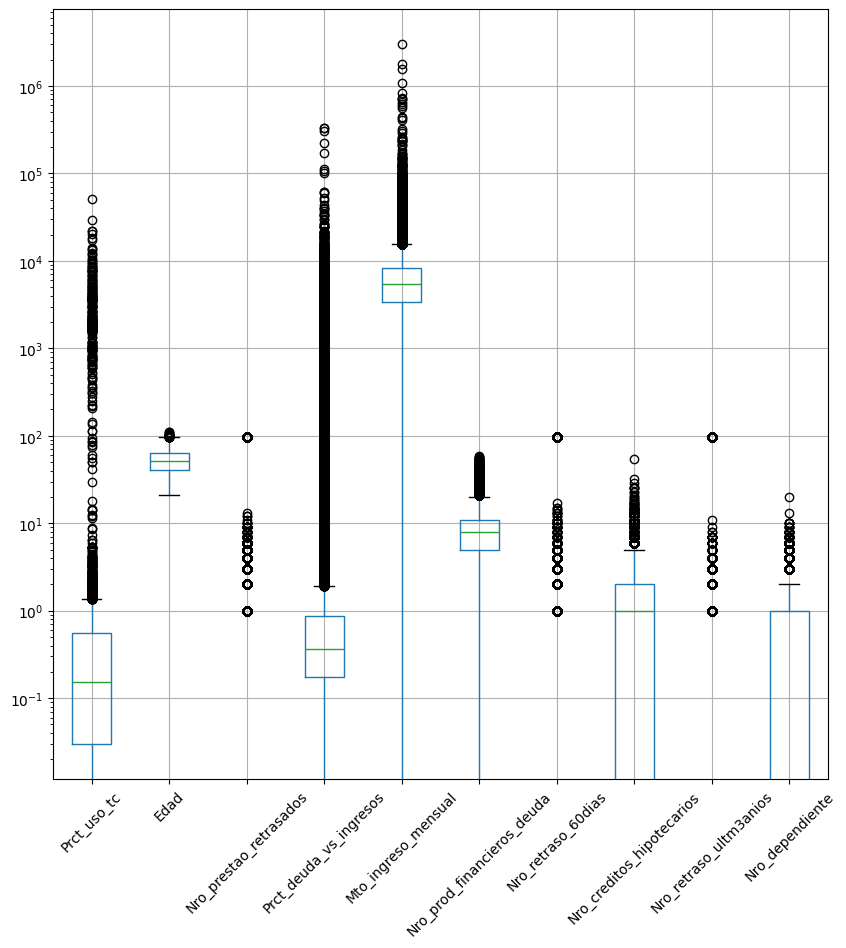

In [11]:
df_clase.drop(columns = ['Default']).boxplot(figsize = (10, 10))
plt.yscale('log')
plt.xticks(rotation = 45)
plt.show()

Tal y como se esperaba luego de ver el grafico de las distribuciones vemos en el grafico de cajas que hay varios outliers en cada variable

*  Los gráficos presentan una distribución altamente asimétrica o sesgada a la derecha
*   Se requieren una escala logarítmica en el eje Y para mostrar adecuadamente la gran variabilidad y la concentración de datos en los valores bajos

*  La mayoría de las observaciones están en el extremo inferior de la escala, indicando un comportamiento "normal" o "típico" de bajo valor.

*  Revelan la presencia de valores extremos o atípicos que se desvían significativamente del patrón general.

La unica variable que no tiene una cola tan pesada seria la Edad

In [12]:
def outliers_col(df):
  for columna in df:
    if df[columna].dtype != object:
      q1 = stats.scoreatpercentile(df[columna], 25)
      q3 = stats.scoreatpercentile(df[columna], 75)
      iqr = q3-q1
      lim_inf = q1-1.5*iqr
      lim_sup = q3+1.5*iqr
      n_outliers_inf = len(df[(df[columna]<lim_inf)])
      n_outliers_sup = len(df[(df[columna]>lim_sup)])
      porcentaje = round((n_outliers_inf+n_outliers_sup)*100/len(df),5)
      print("{} | {} | {}| {}".format(
          df[columna].name,
          n_outliers_inf,
          n_outliers_sup,
          porcentaje
          ))

In [13]:
outliers_col(df_clase)

Default | 0 | 10026| 6.684
Prct_uso_tc | 0 | 763| 0.50867
Edad | 1 | 45| 0.03067
Nro_prestao_retrasados | 0 | 23982| 15.988
Prct_deuda_vs_ingresos | 0 | 31311| 20.874
Mto_ingreso_mensual | 0 | 990| 0.66
Nro_prod_financieros_deuda | 0 | 3980| 2.65333
Nro_retraso_60dias | 0 | 8338| 5.55867
Nro_creditos_hipotecarios | 0 | 793| 0.52867
Nro_retraso_ultm3anios | 0 | 7604| 5.06933
Nro_dependiente | 0 | 13336| 8.89067


Vemos el numero total de olutliers el que tiene mas es la variable Prct_deuda_vs_ingresos seguido de Nro_prestao_retrasados, Nro_dependiente

## **4. DIVISIÓN DE DATOS (TRAIN / TEST)**

In [14]:
X_train, X_test, y_train, y_test = train_test_split(
    df_clase.drop("Default", axis=1),
    df_clase["Default"],
    test_size=0.3,
    random_state=0,
    stratify=df_clase["Default"]
)

print(f"\nForma de Train: {X_train.shape}")
print(f"Forma de Test: {X_test.shape}")



Forma de Train: (105000, 10)
Forma de Test: (45000, 10)


## **5. PREPROCESAMIENTO**

In [16]:
X_train['Mto_ingreso_mensual'] = X_train['Mto_ingreso_mensual'].fillna(X_train['Mto_ingreso_mensual'].mean())
X_train['Nro_dependiente'] = X_train['Nro_dependiente'].fillna(X_train['Nro_dependiente'].median())

X_test['Mto_ingreso_mensual'] = X_test['Mto_ingreso_mensual'].fillna(X_train['Mto_ingreso_mensual'].mean())
X_test['Nro_dependiente'] = X_test['Nro_dependiente'].fillna(X_train['Nro_dependiente'].median())


vars_winsorize_iqr = ['Prct_uso_tc', 'Edad', 'Prct_deuda_vs_ingresos', 'Mto_ingreso_mensual', 'Nro_prod_financieros_deuda']
vars_winsorize_gauss = ['Nro_prestao_retrasados', 'Nro_retraso_60dias', 'Nro_retraso_ultm3anios', 'Nro_creditos_hipotecarios', 'Nro_dependiente']

# Capper IQR
winsor_iqr = Winsorizer(capping_method='iqr', tail='both', fold=1.5, variables=vars_winsorize_iqr)
winsor_iqr.fit(X_train) # Ajusta SÓLO con X_train
X_train_processed = winsor_iqr.transform(X_train)
X_test_processed = winsor_iqr.transform(X_test) # Transforma X_test

# Capper Gaussiano
winsor_gauss = Winsorizer(capping_method='gaussian', tail='both', fold=3, variables=vars_winsorize_gauss)
winsor_gauss.fit(X_train_processed) # Ajusta con X_train_processed
X_train_processed = winsor_gauss.transform(X_train_processed)
X_test_processed = winsor_gauss.transform(X_test_processed) # Transforma X_test_processed

print("Preprocesamiento manual completado.")

Preprocesamiento manual completado.


## **6. SELECCIÓN DE VARIABLES (Omitido)**

In [17]:

# Basado en los resultados, el cálculo de IV no es fiable para este dataset.
# Omitiremos la selección de variables por IV y pasaremos todas las variables
# preprocesadas directamente al modelo.
#
# Los modelos como Random Forest y LightGBM son robustos y realizan su
# propia selección interna de características.
#
print("\nAdvertencia: El cálculo de IV no es fiable. Se omitirá este paso.")

# Simplemente renombramos las variables para que el resto del notebook funcione
X_train_selected = X_train_processed.copy()
X_test_selected = X_test_processed.copy()

print(f"Variables a usar en el modelo: {len(X_train_selected.columns)} (todas las preprocesadas)")


Advertencia: El cálculo de IV no es fiable. Se omitirá este paso.
Variables a usar en el modelo: 10 (todas las preprocesadas)


## **7. MANEJO DE DESBALANCE DE CLASES**

In [18]:
from sklearn.preprocessing import RobustScaler

#
# Hipótesis: RandomOverSampler (ROS) está introduciendo ruido y destruyendo la señal.
# Vamos a OMITIR el oversampling y, en su lugar, usaremos el parámetro
# 'class_weight="balanced"' en los modelos.
#
print("\nSe omite el RandomOverSampler. Se usará 'class_weight' en los modelos.")

# SÍ necesitamos escalar los datos para la Regresión Logística
# Lo ajustamos sobre el set de entrenamiento original (seleccionado)
scaler = RobustScaler()

# Ajustamos el scaler SÓLO con X_train_selected (original, imbalaceado)
X_train_scaled = scaler.fit_transform(X_train_selected)

# Transformamos X_test_selected
X_test_scaled = scaler.transform(X_test_selected)

print("Datos escalados (para Regresión Logística) creados.")

# (Las variables X_train_resampled, y_train_resampled ya no se usarán en esta sección)


Se omite el RandomOverSampler. Se usará 'class_weight' en los modelos.
Datos escalados (para Regresión Logística) creados.


## **8. BENCHMARKING DE MODELOS**

In [19]:
# Modelos con 'class_weight="balanced"' para manejar el desbalance
models = {
    "Logistic Regression": LogisticRegression(random_state=0, solver='liblinear', class_weight='balanced'),
    "LightGBM": LGBMClassifier(random_state=0, class_weight='balanced'),
    "Random Forest (Base)": RandomForestClassifier(random_state=0, class_weight='balanced')
}


In [20]:
print("\n--- Comparación de Modelos (con class_weight='balanced') ---")

# Entrenamos con datos originales (seleccionados), NO rebalanceados
for name, model in models.items():
    if "Regression" in name:
        # La Regresión Logística usa los datos escalados
        model.fit(X_train_scaled, y_train)
        y_pred_proba_test = model.predict_proba(X_test_scaled)[:, 1]
    else:
        # Los árboles no necesitan datos escalados
        model.fit(X_train_selected, y_train)
        y_pred_proba_test = model.predict_proba(X_test_selected)[:, 1]

    roc_auc = roc_auc_score(y_test, y_pred_proba_test)
    print(f"{name} - ROC AUC (Test): {roc_auc:.4f}")


--- Comparación de Modelos (con class_weight='balanced') ---
Logistic Regression - ROC AUC (Test): 0.8547
[LightGBM] [Info] Number of positive: 7018, number of negative: 97982
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012530 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 910
[LightGBM] [Info] Number of data points in the train set: 105000, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
LightGBM - ROC AUC (Test): 0.8655
Random Forest (Base) - ROC AUC (Test): 0.8350


## **9. ENTRENAMIENTO PROFUNDO (RANDOM FOREST)**

In [21]:
print("\nIniciando búsqueda de hiperparámetros para Random Forest...")

rf = RandomForestClassifier(random_state=0)

# Corregido el '0. 05'
rf_param_grid = dict(
    n_estimators=[10, 20, 50, 100, 200],
    max_depth=[None, 2, 3, 5, 10, 15, 20],
    max_features=['sqrt', 'log2', 0.5],
    bootstrap=[True, False],
    min_samples_split=[0.01, 0.05, 0.1, 0.2, 0.5], # Corregido
    min_samples_leaf=[1, 2, 5]
)

# Random Search (n_iter=100 es un buen balance)
random_search = RandomizedSearchCV(
    rf,
    rf_param_grid,
    scoring='roc_auc',
    cv=5,
    n_iter=100, # 100 iteraciones
    n_jobs=-1,
    random_state=0,
    verbose=1
)

search_rf = random_search.fit(X_train_selected, y_train)

print("\nMejores parámetros (Random Forest):", search_rf.best_params_)
print(f"Mejor ROC AUC (CV): {search_rf.best_score_:.4f}")

# Modelo final
final_rf_model = search_rf.best_estimator_



Iniciando búsqueda de hiperparámetros para Random Forest...
Fitting 5 folds for each of 100 candidates, totalling 500 fits

Mejores parámetros (Random Forest): {'n_estimators': 100, 'min_samples_split': 0.01, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 15, 'bootstrap': False}
Mejor ROC AUC (CV): 0.8632


## **10. EVALUACIÓN FINAL DEL MODELO**

In [22]:
print("\n--- EVALUACIÓN EN CONJUNTO DE PRUEBA (TEST) ---")

# --- Predicciones ---
# Sobre Train (para comparar overfitting)
# (Usamos X_train_selected, que son los datos que el modelo vio)
y_pred_proba_train = final_rf_model.predict_proba(X_train_selected)[:, 1]
y_pred_class_train = final_rf_model.predict(X_train_selected)

# ¡SOBRE TEST!
y_pred_proba_test = final_rf_model.predict_proba(X_test_selected)[:, 1]
y_pred_class_test = final_rf_model.predict(X_test_selected)

# --- Métricas ---
# (El título "Resampled" estaba mal, lo corregí a "Original")
print("\n--- Métricas del Set de Entrenamiento (Original) ---")

# --- ¡CORRECCIÓN AQUÍ! ---
# Usamos 'y_train' en lugar de 'X_train_selected'
print(f"ROC AUC (Train): {roc_auc_score(y_train, y_pred_proba_train):.4f}")
print(f"Accuracy (Train): {accuracy_score(y_train, y_pred_class_train):.4f}")
print(f"Balanced Accuracy (Train): {balanced_accuracy_score(y_train, y_pred_class_train):.4f}")
# --- FIN DE LA CORRECCIÓN ---



--- EVALUACIÓN EN CONJUNTO DE PRUEBA (TEST) ---

--- Métricas del Set de Entrenamiento (Original) ---
ROC AUC (Train): 0.8887
Accuracy (Train): 0.9367
Balanced Accuracy (Train): 0.5573


In [23]:
print("\n--- Métricas del Set de Prueba (Test) ---")
print(f"ROC AUC (Test): {roc_auc_score(y_test, y_pred_proba_test):.4f}")
print(f"Accuracy (Test): {accuracy_score(y_test, y_pred_class_test):.4f}")
print(f"Balanced Accuracy (Test): {balanced_accuracy_score(y_test, y_pred_class_test):.4f}")
print(f"Brier Score (Test): {brier_score_loss(y_test, y_pred_proba_test):.4f}")


--- Métricas del Set de Prueba (Test) ---
ROC AUC (Test): 0.8650
Accuracy (Test): 0.9361
Balanced Accuracy (Test): 0.5554
Brier Score (Test): 0.0493


In [24]:
# --- Reporte de Clasificación (Test) ---
print("\nReporte de Clasificación (Test):")
print(classification_report(y_test, y_pred_class_test))



Reporte de Clasificación (Test):
              precision    recall  f1-score   support

           0       0.94      0.99      0.97     41992
           1       0.62      0.12      0.20      3008

    accuracy                           0.94     45000
   macro avg       0.78      0.56      0.58     45000
weighted avg       0.92      0.94      0.92     45000




Matriz de Confusión (Test):


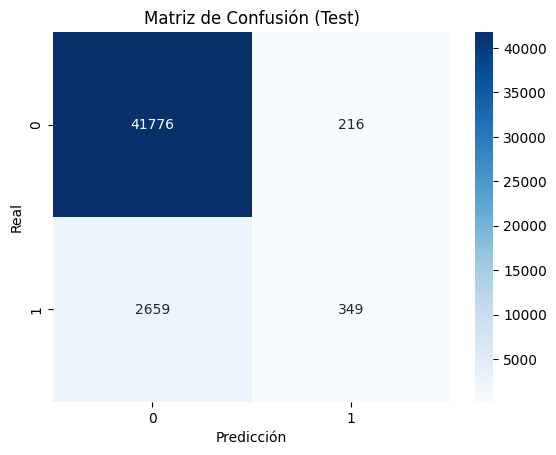

In [25]:
# --- Matriz de Confusión (Test) ---
print("\nMatriz de Confusión (Test):")
cm = confusion_matrix(y_test, y_pred_class_test)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión (Test)')
plt.show()

## **11. MÉTRICAS AVANZADAS (KS y Calibración)**

### **11.1 Estadístico Kolmogorov-Smirnov (KS)**


Estadístico KS (Test): nan


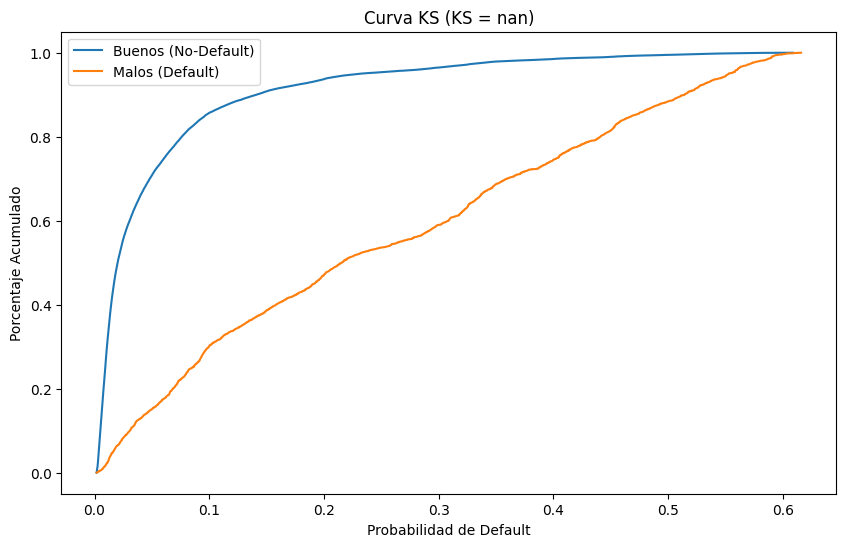

In [26]:
df_ks = pd.DataFrame({'label': y_test, 'proba': y_pred_proba_test})
df_ks_good = df_ks[df_ks['label'] == 0].sort_values('proba')
df_ks_bad = df_ks[df_ks['label'] == 1].sort_values('proba')

df_ks_good['pct_acum'] = df_ks_good['proba'].rank(pct=True)
df_ks_bad['pct_acum'] = df_ks_bad['proba'].rank(pct=True)

ks_statistic = np.max(df_ks_good['pct_acum'] - df_ks_bad['pct_acum'])
print(f"\nEstadístico KS (Test): {ks_statistic * 100:.2f}")

plt.figure(figsize=(10, 6))
plt.plot(df_ks_good['proba'], df_ks_good['pct_acum'], label='Buenos (No-Default)')
plt.plot(df_ks_bad['proba'], df_ks_bad['pct_acum'], label='Malos (Default)')
plt.legend()
plt.title(f"Curva KS (KS = {ks_statistic * 100:.2f})")
plt.xlabel("Probabilidad de Default")
plt.ylabel("Porcentaje Acumulado")
plt.show()

### **11.2 Curva de Calibración**


Curva de Calibración:


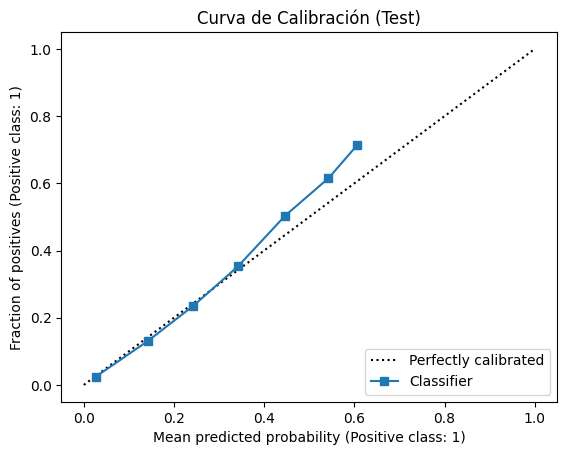

In [27]:
print("\nCurva de Calibración:")
fig, ax = plt.subplots()
CalibrationDisplay.from_predictions(y_test, y_pred_proba_test, n_bins=10, ax=ax)
ax.set_title("Curva de Calibración (Test)")
plt.show()

## **12. INTERPRETABILIDAD DEL MODELO (SHAP)**


Calculando valores SHAP para interpretabilidad...


100%|===================| 89971/90000 [30:40<00:00]       


Importancia Global de Variables (SHAP):


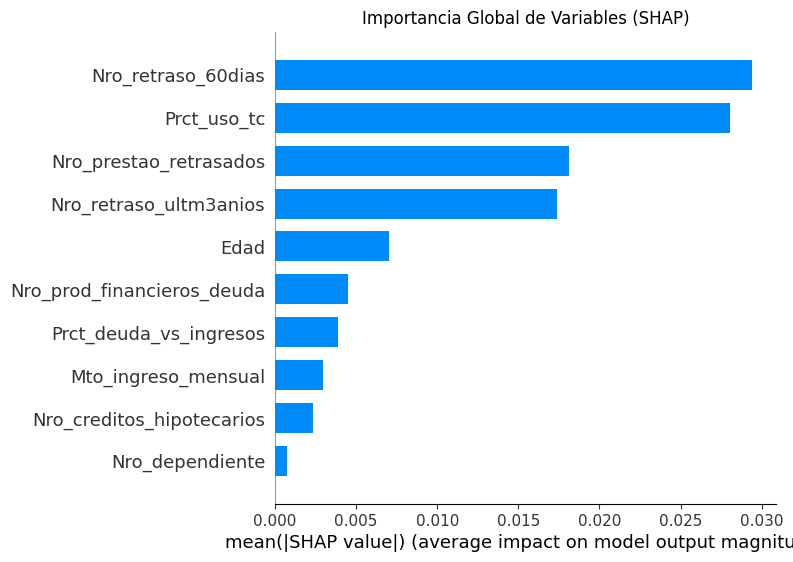

In [28]:
import shap
print("\nCalculando valores SHAP para interpretabilidad...")

# --- CORRECCIÓN DE API ---
# 1. Creamos el explainer usando la API moderna (Explainer)
#    Le pasamos el modelo Y los datos de entrenamiento (X_train_selected)
#    como "background" para que entienda la distribución de los datos.
explainer = shap.Explainer(final_rf_model, X_train_selected)

# 2. Calculamos los valores SHAP en los datos de prueba.
#    Esto crea un objeto "Explanation" especial.++
shap_values_obj = explainer(X_test_selected)

# 3. Para obtener los valores de la clase "Default" (clase 1), usamos slicing.
#    Esto selecciona [todas_las_muestras, todas_las_features, clase_1]
shap_values_class_1 = shap_values_obj[:,:,1]
# --- FIN DE LA CORRECCIÓN ---


# SHAP da 2 salidas (clase 0, clase 1). Usamos la [1] (Default)
print("\nImportancia Global de Variables (SHAP):")

# Pasamos el objeto de SHAP para la clase 1 y los datos de prueba
shap.summary_plot(shap_values_class_1, X_test_selected, plot_type="bar", show=False)
plt.title("Importancia Global de Variables (SHAP)")
plt.show()



Impacto Detallado de Variables (SHAP):


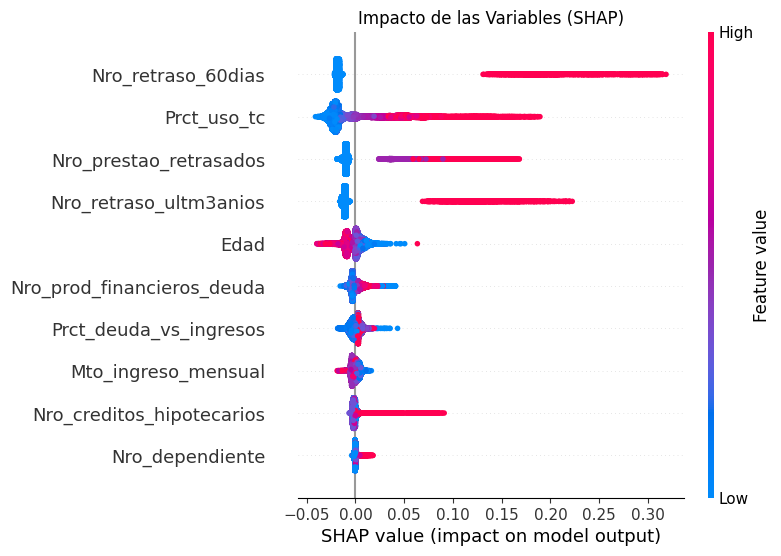

In [29]:

print("\nImpacto Detallado de Variables (SHAP):")
# Hacemos lo mismo para el gráfico de "beeswarm"
shap.summary_plot(shap_values_class_1, X_test_selected, show=False)
plt.title("Impacto de las Variables (SHAP)")
plt.show()

## **13. ANÁLISIS DEL PUNTO DE CORTE**

In [30]:
# Encontrar el punto de corte óptimo usando la curva ROC del conjunto de PRUEBA
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_test)
gmeans = np.sqrt(tpr * (1 - fpr))
optimal_idx = np.argmax(gmeans)
optimal_threshold = thresholds[optimal_idx]

### **13.1 Aplicar el corte óptimo**

In [31]:
print(f"\nPunto de corte óptimo (G-Mean): {optimal_threshold:.4f}")
preds_test = pd.DataFrame({
    'prob_default': y_pred_proba_test,
    'Default_Real': y_test
})

preds_test['Default_Pred_Corte_Optimo'] = preds_test['prob_default'].apply(lambda x: 1 if x > optimal_threshold else 0)


Punto de corte óptimo (G-Mean): 0.0777


### **13.2 Métricas con el punto de corte óptimo (Test)**


--- Métricas con Punto de Corte Óptimo (Test) ---
Accuracy (Corte Óptimo): 0.8029
Balanced Accuracy (Corte Óptimo): 0.7887

Reporte de Clasificación (Corte Óptimo):
              precision    recall  f1-score   support

           0       0.98      0.81      0.88     41992
           1       0.22      0.77      0.34      3008

    accuracy                           0.80     45000
   macro avg       0.60      0.79      0.61     45000
weighted avg       0.93      0.80      0.85     45000


Matriz de Confusión (Corte Óptimo):


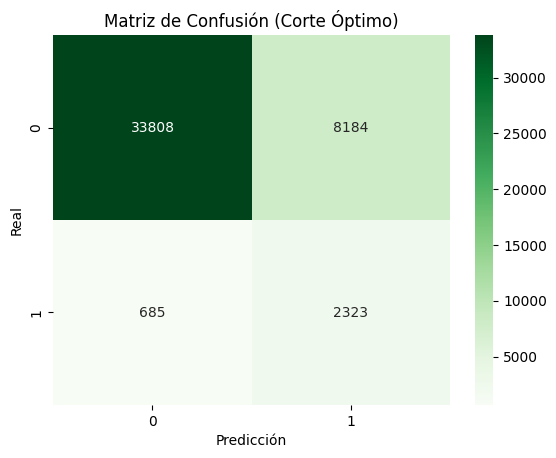

In [32]:
print("\n--- Métricas con Punto de Corte Óptimo (Test) ---")
print(f"Accuracy (Corte Óptimo): {accuracy_score(preds_test['Default_Real'], preds_test['Default_Pred_Corte_Optimo']):.4f}")
print(f"Balanced Accuracy (Corte Óptimo): {balanced_accuracy_score(preds_test['Default_Real'], preds_test['Default_Pred_Corte_Optimo']):.4f}")

print("\nReporte de Clasificación (Corte Óptimo):")
print(classification_report(preds_test['Default_Real'], preds_test['Default_Pred_Corte_Optimo']))

print("\nMatriz de Confusión (Corte Óptimo):")
cm_opt = confusion_matrix(preds_test['Default_Real'], preds_test['Default_Pred_Corte_Optimo'])
sns.heatmap(cm_opt, annot=True, fmt='d', cmap='Greens')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión (Corte Óptimo)')
plt.show()